The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

(chapter-non-periodic-signals)=
# Non-Periodic Signals

The signals we have worked with so far are periodic, which means that they repeat forever.
It also means that the frequency components they contain do not change over time.
In this chapter, we consider non-periodic signals, whose frequency components *do* change over time.
In other words, pretty much all sound signals.

This chapter also presents spectrograms, a common way to visualize non-periodic signals.

The code for this chapter is in `chap03.ipynb`, which is in the repository for this book (see Section [\[code\]](#code){reference-type="ref" reference="code"}).
You can also view it at <http://tinyurl.com/thinkdsp03>.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap03.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate_time, decorate_freq, decorate_gram

(section-linear-chirp)=
## Linear Chirp

We'll start with a **chirp**, which is a signal with variable frequency.
`thinkdsp` provides a Signal called Chirp that makes a sinusoid that sweeps linearly through a range of frequencies.

Here's an example that sweeps from 220 to 880 Hz, which is two octaves from A3 to A5:

In [4]:
from thinkdsp import Chirp

signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

Here's what the waveform looks like near the beginning:

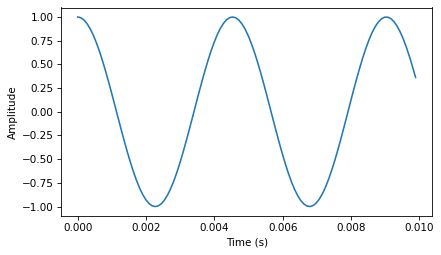

In [5]:
wave1.segment(start=0, duration=0.01).plot()
decorate_time()

And near the end:

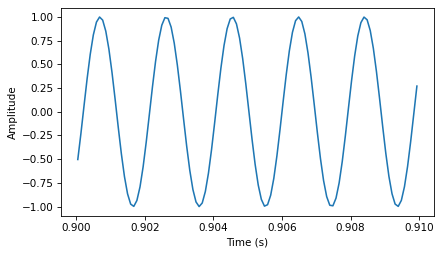

In [6]:
wave1.segment(start=0.9, duration=0.01).plot()
decorate_time()

It's clear that the frequency is increasing.

Before we go on, let's see how Chirp is implemented.
Here is the class definition:

In [7]:
from thinkdsp import Signal, PI2

class Chirp(Signal):

    def __init__(self, start=440, end=880, amp=1.0):
        self.start = start
        self.end = end
        self.amp = amp

`start` and `end` are the frequencies, in Hz, at the start and end of the chirp.
`amp` is amplitude.

Here is the function that evaluates the signal:

In [8]:
%%add_method_to Chirp

def evaluate(self, ts):
    freqs = np.linspace(self.start, self.end, len(ts))
    dts = np.diff(ts, prepend=0)
    dphis = PI2 * freqs * dts
    phases = np.cumsum(dphis)
    ys = self.amp * np.cos(phases)
    return ys

`ts` is the sequence of points in time where the signal should be evaluated; to keep this function simple, I assume they are equally-spaced.

To compute the frequency at each point in time, I use `np.linspace`, which returns a NumPy array of $n$ values between `start` and `end`.

`np.diff` computes the difference between adjacent elements of `ts`, returning the length of each interval in seconds.
If the elements of `ts` are equally spaced, the `dts` are all the same.

The next step is to figure out how much the phase changes during each interval.
In Section [\[sigobs\]](#sigobs){reference-type="ref" reference="sigobs"} we saw that when frequency is constant, the phase, $\phi$, increases linearly over time: $$\phi = 2 \pi f t$$ When frequency is a function of time, the *change* in phase during a short time interval, $\Delta t$ is: $$\Delta \phi = 2 \pi f(t) \Delta t$$ In Python, since `freqs` contains $f(t)$ and `dts` contains the time intervals, we can write

In [9]:
# dphis = PI2 * freqs * dts

Now, since `dphis` contains the changes in phase, we can get the total phase at each timestep by adding up the changes:

In [10]:
# phases = np.cumsum(dphis)
# phases = np.insert(phases, 0, 0)

`np.cumsum` computes the cumulative sum, which is almost what we want, but it doesn't start at 0. So I use `np.insert` to add a 0 at the beginning.

The result is a NumPy array where the `i`th element contains the sum of the first `i` terms from `dphis`; that is, the total phase at the end of the `i`th interval.
Finally, `np.cos` computes the amplitude of the wave as a function of phase (remember that phase is expressed in radians).

If you know calculus, you might notice that the limit as $\Delta t$ gets small is $$d\phi = 2 \pi f(t) dt$$ Dividing through by $dt$ yields $$\frac{d\phi}{dt} = 2 \pi f(t)$$ In other words, frequency is the derivative of phase.
Conversely, phase is the integral of frequency.
When we used `cumsum` to go from frequency to phase, we were approximating integration.

(section-exponential-chirp)=
## Exponential Chirp

When you listen to this chirp, you might notice that the pitch rises quickly at first and then slows down.
The chirp spans two octaves, but it only takes 2/3 s to span the first octave, and twice as long to span the second.

The reason is that our perception of pitch depends on the logarithm of frequency.
As a result, the **interval** we hear between two notes depends on the *ratio* of their frequencies, not the difference.
"Interval" is the musical term for the perceived difference between two pitches.

For example, an octave is an interval where the ratio of two pitches is 2. So the interval from 220 to 440 is one octave and the interval from 440 to 880 is also one octave.
The difference in frequency is bigger, but the ratio is the same.

As a result, if frequency increases linearly, as in a linear chirp, the perceived pitch increases logarithmically.

If you want the perceived pitch to increase linearly, the frequency has to increase exponentially.
A signal with that shape is called an **exponential chirp**.

Here's an exponential chirp with the same frequency range and duration:

In [11]:
from thinkdsp import ExpoChirp

signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

Here's the code that makes one:

In [12]:
class ExpoChirp(Chirp):

    def evaluate(self, ts):
        start, end = np.log10(self.start), np.log10(self.end)
        freqs = np.logspace(start, end, len(ts)-1)
        return self._evaluate(ts, freqs)

Instead of `np.linspace`, this version of evaluate uses `np.logspace`, which creates a series of frequencies whose logarithms are equally spaced, which means that they increase exponentially.

That's it; everything else is the same as Chirp.

You can listen to these examples in `chap03.ipynb` and compare the linear and exponential chirps.

(section-spectrum-of-a-chirp)=
## Spectrum of a Chirp

What do you think happens if you compute the spectrum of a chirp? Here's an example that constructs a one-second, one-octave chirp and its spectrum:

In [13]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()

The spectrum has components at every frequency from 220 to 440 Hz, with variations that look a little like the Eye of Sauron (see <http://en.wikipedia.org/wiki/Sauron>).

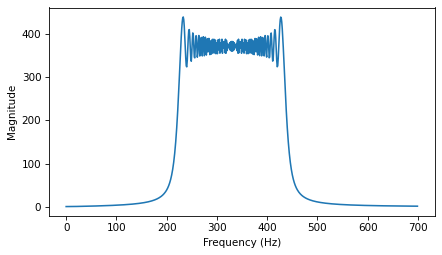

In [14]:
spectrum.plot(high=700)
decorate_freq()

The spectrum is approximately flat between 220 and 440 Hz, which indicates that the signal spends equal time at each frequency in this range.
Based on that observation, you should be able to guess what the spectrum of an exponential chirp looks like.

The spectrum gives hints about the structure of the signal, but it obscures the relationship between frequency and time.
For example, we cannot tell by looking at this spectrum whether the frequency went up or down, or both.

(section-spectrogram)=
## Spectrogram

To recover the relationship between frequency and time, we can break the chirp into segments and plot the spectrum of each segment.
The result is called a **short-time Fourier transform** (STFT).

There are several ways to visualize a STFT, but the most common is a **spectrogram**, which shows time on the x-axis and frequency on the y-axis.
Each column in the spectrogram shows the spectrum of a short segment, using color or grayscale to represent amplitude.

As an example, I'll compute the spectrogram of this chirp:

In [15]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)

`Wave` provides `make_spectrogram`, which returns a `Spectrogram` object:

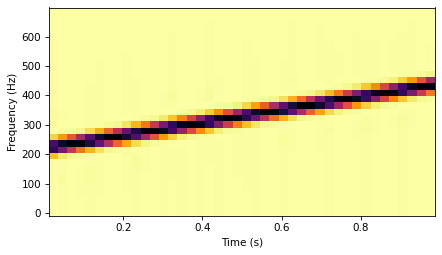

In [16]:
spectrogram = wave.make_spectrogram(seg_length=512)
spectrogram.plot(high=700)
decorate_gram()

`seg_length` is the number of samples in each segment.
I chose 512 because FFT is most efficient when the number of samples is a power of 2.

The x-axis shows time from 0 to 1 seconds.
The y-axis shows frequency from 0 to 700 Hz. I cut off the top part of the spectrogram; the full range goes to 5512.5 Hz, which is half of the framerate.

The spectrogram shows clearly that frequency increases linearly over time.
Similarly, in the spectrogram of an exponential chirp, we can see the shape of the exponential curve.

However, notice that the peak in each column is blurred across 2--3 cells.
This blurring reflects the limited resolution of the spectrogram.

(section-the-gabor-limit)=
## The Gabor Limit

The **time resolution** of the spectrogram is the duration of the segments, which corresponds to the width of the cells in the spectrogram.
Since each segment is 512 frames, and there are 11,025 frames per second, the duration of each segment is about 0.046 seconds.

The **frequency resolution** is the frequency range between elements in the spectrum, which corresponds to the height of the cells.
With 512 frames, we get 256 frequency components over a range from 0 to 5512.5 Hz, so the range between components is 21.6 Hz.

More generally, if $n$ is the segment length, the spectrum contains $n/2$ components.
If the framerate is $r$, the maximum frequency in the spectrum is $r/2$.
So the time resolution is $n/r$ and the frequency resolution is $$\frac{r/2}{n/2}$$ which is $r/n$.

Ideally we would like time resolution to be small, so we can see rapid changes in frequency.
And we would like frequency resolution to be small so we can see small changes in frequency.
But you can't have both.
Notice that time resolution, $n/r$, is the inverse of frequency resolution, $r/n$.
So if one gets smaller, the other gets bigger.

For example, if you double the segment length, you cut frequency resolution in half (which is good), but you double time resolution (which is bad).
Even increasing the framerate doesn't help.
You get more samples, but the range of frequencies increases at the same time.

This tradeoff is called the **Gabor limit** and it is a fundamental limitation of this kind of time-frequency analysis.

(section-leakage)=
## Leakage

In order to explain how `make_spectrogram` works, I have to explain windowing; and in order to explain windowing, I have to show you the problem it is meant to address, which is leakage.

The Discrete Fourier Transform (DFT), which we use to compute Spectrums, treats waves as if they are periodic; that is, it assumes that the finite segment it operates on is a complete period from an infinite signal that repeats over all time.
In practice, this assumption is often false, which creates problems.

One common problem is discontinuity at the beginning and end of the segment.
Because DFT assumes that the signal is periodic, it implicitly connects the end of the segment back to the beginning to make a loop.
If the end does not connect smoothly to the beginning, the discontinuity creates additional frequency components in the segment that are not in the signal.

As an example, let's start with a sine signal that contains only one frequency component at 440 Hz.

In [17]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)

If we select a segment that happens to be an integer multiple of the period, the end of the segment connects smoothly with the beginning, and DFT behaves well.

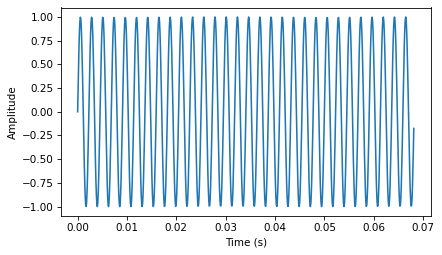

In [18]:
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate_time()

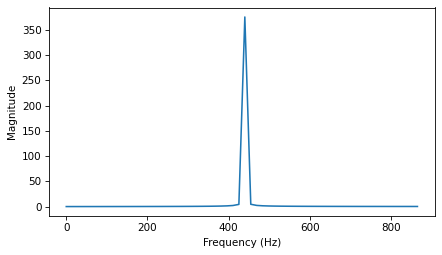

In [19]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate_freq()

As expected, there is a single peak at 440 Hz.

But if the duration is not a multiple of the period, bad things happen.
With `duration = signal.period * 30.25`, the signal starts at 0 and ends at 1.

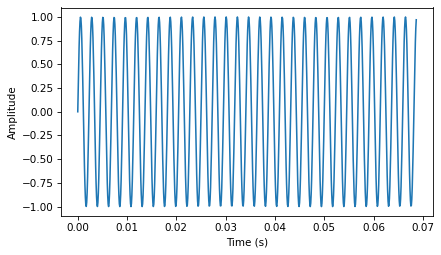

In [20]:
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate_time()

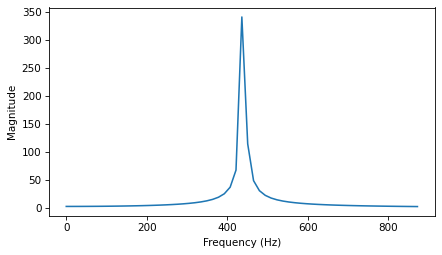

In [21]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate_freq()

Again, the peak is at 440 Hz, but now there are additional components spread out from 240 to 640 Hz. This spread is called **spectral leakage**, because some of the energy that is actually at the fundamental frequency leaks into other frequencies.

In this example, leakage happens because we are using DFT on a segment that becomes discontinuous when we treat it as periodic.

Windowing helps (but notice that it reduces the total energy).

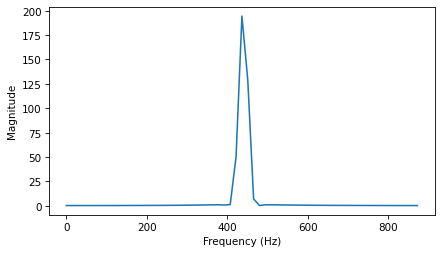

In [22]:
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate_freq()

(section-windowing)=
## Windowing

We can reduce leakage by smoothing out the discontinuity between the beginning and end of the segment, and one way to do that is **windowing**.

A "window" is a function designed to transform a non-periodic segment into something that can pass for periodic.
Figure [\[fig.windowing2\]](#fig.windowing2){reference-type="ref" reference="fig.windowing2"} (top) shows a segment where the end does not connect smoothly to the beginning.

Figure [\[fig.windowing2\]](#fig.windowing2){reference-type="ref" reference="fig.windowing2"} (middle) shows a "Hamming window", one of the more common window functions.
No window function is perfect, but some can be shown to be optimal for different applications, and Hamming is a good, all-purpose window.

Figure [\[fig.windowing2\]](#fig.windowing2){reference-type="ref" reference="fig.windowing2"} (bottom) shows the result of multiplying the window by the original signal.
Where the window is close to 1, the signal is unchanged.
Where the window is close to 0, the signal is attenuated.
Because the window tapers at both ends, the end of the segment connects smoothly to the beginning.

Figure [\[fig.windowing1\]](#fig.windowing1){reference-type="ref" reference="fig.windowing1"} (right) shows the spectrum of the windowed signal.
Windowing has reduced leakage substantially, but not completely.

Here's what the code looks like.
`Wave` provides `window`, which applies a Hamming window:

In [23]:
def window(self, window):
    self.ys *= window

And NumPy provides `hamming`, which computes a Hamming window with a given length:

In [24]:
window = np.hamming(len(wave))
wave.window(window)

NumPy provides functions to compute other window functions, including `bartlett`, `blackman`, `hanning`, and `kaiser`.
One of the exercises at the end of this chapter asks you to experiment with these other windows.

(section-implementing-spectrograms)=
## Implementing Spectrograms

Now that we understand windowing, we can understand the implementation of spectrogram.
Here is the `Wave` method that computes spectrograms:

In [25]:
#class Wave:
def make_spectrogram(self, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    spec_map = {}

    while j < len(self.ys):
        segment = self.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_spectrum()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

This is the longest function in the book, so if you can handle this, you can handle anything.

The parameter, `self`, is a Wave object.
`seg_length` is the number of samples in each segment.

`window` is a Hamming window with the same length as the segments.

`i` and `j` are the slice indices that select segments from the wave.
`step` is the offset between segments.
Since ` step` is half of `seg_length`, the segments overlap by half.
Figure [\[fig.windowing3\]](#fig.windowing3){reference-type="ref" reference="fig.windowing3"} shows what these overlapping windows look like.

`spec_map` is a dictionary that maps from a timestamp to a Spectrum.

Inside the while loop, we select a slice from the wave and apply the window; then we construct a Spectrum object and add it to `spec_map`.
The nominal time of each segment, `t`, is the midpoint.

Then we advance `i` and `j`, and continue as long as `j` doesn't go past the end of the Wave.

Finally, the method constructs and returns a Spectrogram.
Here is the definition of Spectrogram:

In [26]:
class Spectrogram(object):
    def __init__(self, spec_map, seg_length):
        self.spec_map = spec_map
        self.seg_length = seg_length

Like many init methods, this one just stores the parameters as attributes.

`Spectrogram` provides `plot`, which generates a pseudocolor plot with time along the x-axis and frequency along the y-axis.

And that's how Spectrograms are implemented.

## Exercises

### Exercise 3.1

Run and listen to the examples in chap03.ipynb.
In the leakage example, try replacing the Hamming window with one of the other windows provided by NumPy, and see what effect they have on leakage.

See http://docs.scipy.org/doc/numpy/reference/routines.window.html

Here's the leakage example:

In [27]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()

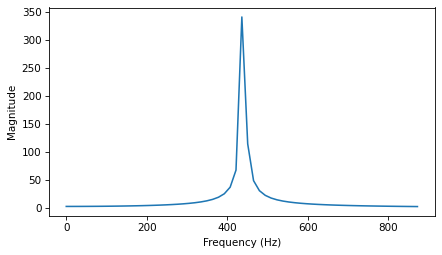

In [28]:
spectrum.plot(high=880)
decorate_freq()

The following figure shows the effect of 4 different windows.

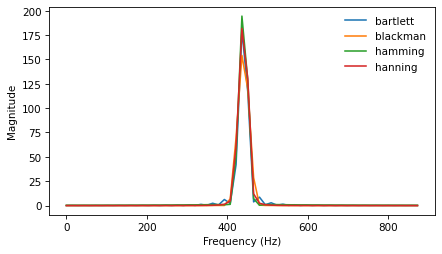

In [29]:
for window_func in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(duration)
    wave.ys *= window_func(len(wave.ys))

    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=window_func.__name__)

decorate_freq()

All four do a good job of reducing leakage.
The Bartlett filter leaves some residual "ringing".
The Hamming filter dissipates the least amount of energy.

### Exercise 3.2

Write a class called `SawtoothChirp` that extends `Chirp` and overrides evaluate to generate a sawtooth waveform with frequency that increases (or decreases) linearly.

My solution:

In [30]:
from thinkdsp import Chirp
from thinkdsp import normalize, unbias

PI2 = 2 * np.pi

class SawtoothChirp(Chirp):
    """Represents a sawtooth signal with varying frequency."""

    def evaluate(self, ts):
        """Helper function that evaluates the signal.

        ts: float array of times
        """
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys =  normalize(unbias(frac), self.amp)
        return ys

Here's what it sounds like.

In [31]:
signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.make_audio()

And here's the spectrogram.

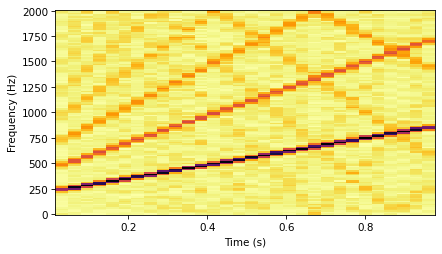

In [32]:
sp = wave.make_spectrogram(256)
sp.plot()
decorate_gram()

At a relatively low frame rate, you can see the aliased harmonics bouncing off the folding frequency.
And you can hear them as a background hiss.
If you crank up the frame rate, they go away.

By the way, if you are a fan of the original Star Trek series, you might recognize the sawtooth chirp as the red alert signal:

In [33]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/tos-redalert.wav')

In [34]:
from thinkdsp import read_wave

read_wave('tos-redalert.wav').make_audio()

/home/downey/ThinkDSP2/soln/thinkdsp.py:1087: RuntimeWarning: overflow encountered in scalar absolute
  high, low = abs(max(ys)), abs(min(ys))


### Exercise 3.3

Make a sawtooth chirp that sweeps from 2500 to 3000 Hz, then make a wave with duration 1 and framerate 20 kHz.
Draw a sketch of what you think the spectrum will look like.
Then plot the spectrum and see if you got it right.

Since the fundamental sweeps from 2500 to 3000 Hz, I expect to see something like the Eye of Sauron in that range.
The first harmonic sweeps from 5000 to 6000 Hz, so I expect a shorter tower in that range, like the Outhouse of Sauron.
The second harmonic sweeps from 7500 to 9000 Hz, so I expect something even shorter in that range, like the Patio of Sauron.

The other harmonics get aliased all over the place, so I expect to see some energy at all other frequencies.
This distributed energy creates some interesting sounds.

In [35]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

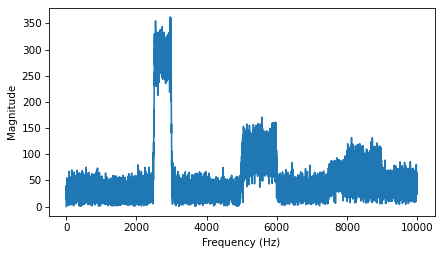

In [36]:
wave.make_spectrum().plot()
decorate_freq()

### Exercise 3.4

In musical terminology, a "glissando" is a note that slides from one pitch to another, so it is similar to a chirp.
Find or make a recording of a glissando and plot its spectrogram.

One suggestion: George Gershwin's *Rhapsody in Blue* starts with a famous clarinet glissando; you can download a recording from http://archive.org/details/rhapblue11924.

Here's an example:

In [37]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/72475__rockwehrmann__glissup02.wav')

In [38]:
wave = read_wave('72475__rockwehrmann__glissup02.wav')
wave.make_audio()

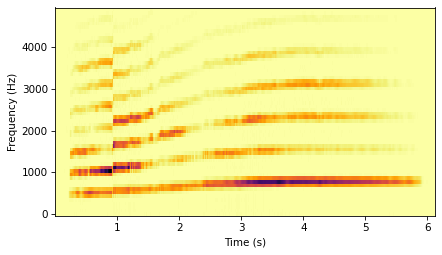

In [39]:
wave.make_spectrogram(512).plot(high=5000)
decorate_gram()

### Exercise 3.5

A trombone player can play a glissando by extending the trombone slide while blowing continuously.
As the slide extends, the total length of the tube gets longer, and the resulting pitch is inversely proportional to length.
Assuming that the player moves the slide at a constant speed, how does frequency vary with time?  

Write a class called `TromboneGliss` that extends `Chirp` and provides `evaluate`.
Make a wave that simulates a trombone glissando from F3 down to C3 and back up to F3.  C3 is 262 Hz; F3 is 349 Hz.

Plot a spectrogram of the resulting wave.
Is a trombone glissando more like a linear or exponential chirp?

Here's my solution:

In [40]:
class TromboneGliss(Chirp):
    """Represents a trombone-like signal with varying frequency."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths
        
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

Here's the first part of the wave:

In [41]:
low = 262
high = 349
signal = TromboneGliss(high, low)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

And the second part:

In [42]:
signal = TromboneGliss(low, high)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

Putting them together:

In [43]:
wave = wave1 | wave2
wave.make_audio()

Here's the spectrogram:

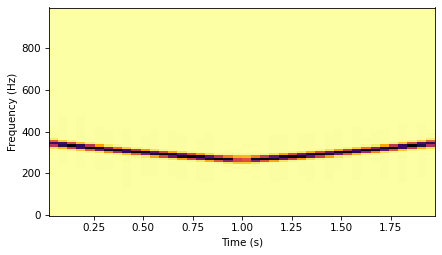

In [44]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)
decorate_gram()

The curve in the spectrogram looks more like an exponential chirp than a linear one.

### Exercise 3.6

Make or find a recording of a series of vowel sounds and look at the spectrogram.
Can you identify different vowels?

Here's an example:

In [45]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/87778__marcgascon7__vocals.wav')

In [46]:
wave = read_wave('87778__marcgascon7__vocals.wav')
wave.make_audio()

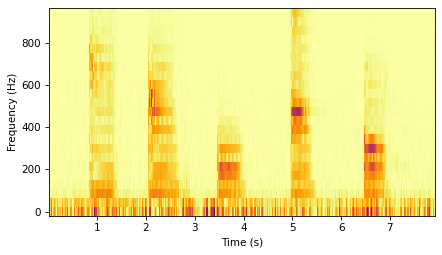

In [47]:
wave.make_spectrogram(1024).plot(high=1000)
decorate_gram()

The stripe across the bottom is probably background noise.
The peaks in the spectrogram are called "formants".

In general, vowel sounds are distinguished by the amplitude ratios of the first two formants relative to the fundamental.
For more, see https://en.wikipedia.org/wiki/Formant

We can see the formats more clearly by selecting a segment during 'ah'.

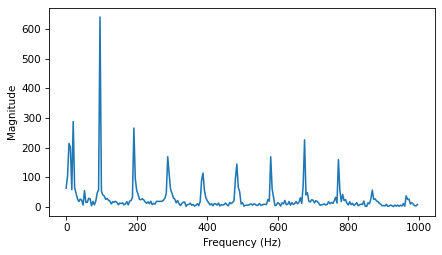

In [48]:
high = 1000

segment = wave.segment(start=1, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate_freq()

The fundamental is near 100 Hz.  The next highest peaks are at 200 Hz and 700 Hz.  People who know more about this than I do can identify vowels by looking at spectrums, but I can't.

The 'eh' segment has a high-amplitude formant near 500 Hz.

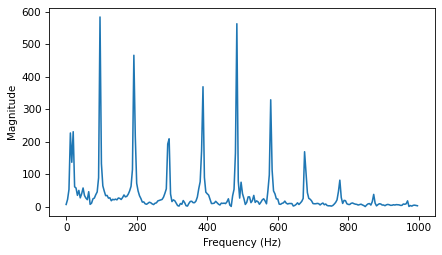

In [49]:
segment = wave.segment(start=2.2, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate_freq()

The 'ih' segment has no high frequency components.

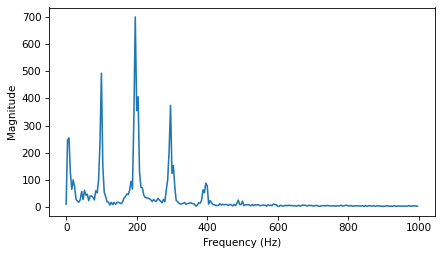

In [50]:
segment = wave.segment(start=3.5, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate_freq()

The 'oh' segment has a high-amplitude formant near 500 Hz, even higher than the fundamental.

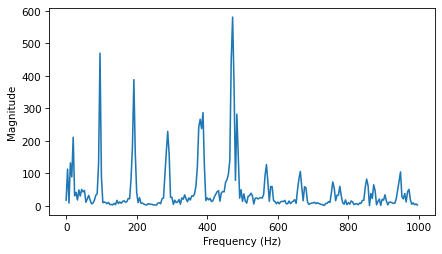

In [51]:
segment = wave.segment(start=5.1, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate_freq()

The 'oo' segment has a high-amplitude formant near 300 Hz and no high-frequency components

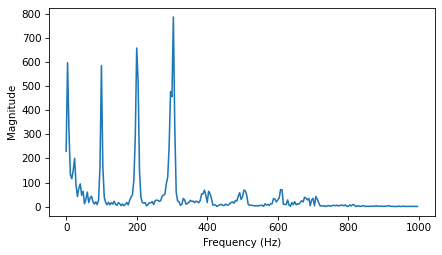

In [52]:
segment = wave.segment(start=6.5, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate_freq()

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)